## Riksarkivet SBL  - Wikidata ett försök att synka och dansa med dom
version 0.47 this [notebook](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb)

WD egenskap [Property:P3217](https://www.wikidata.org/wiki/Property:P3217) 
* SBL personartiklar som saknar [sv:Wikipedia artikel](https://w.wiki/c5f) < 150
* [SBL vs SKBL female articles](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)  

#### Andra källor vi synkar
* [Kulturpersoner Uppsalakyrkogård](https://github.com/salgo60/open-data-examples/blob/master/Check%20WD%20kulturpersoner%20uppsalakyrkogardar.ipynb)
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb) 
  * WD property [P5101](https://www.wikidata.org/wiki/Property_talk:P5101) [P5123](https://www.wikidata.org/wiki/Property_talk:P5123)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
  * WD [property 8024](https://www.wikidata.org/wiki/Property:P8024)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) 
  * WD [property 3217](https://www.wikidata.org/wiki/Property:P3217) 
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)
  * WD [property 4963](https://www.wikidata.org/wiki/Property:P4963)
* [Svenska Akademien](https://github.com/salgo60/open-data-examples/blob/master/Svenska%20Akademien.ipynb) 
  * WD [property 5325](https://www.wikidata.org/wiki/Property:P5325) 

### SBL
SBL har idag
* personartiklar
* släktartiklar
  * en person i en släktartikel kan ha en sida som bara pekar till släktartikeln (med text ej alltid länk)

Det saknas idag från Riksarkivet ett API så nedanstående är ett försök att webscrapa deras data och sedan försöka hitta en struktur. 

Målsättningen är att ha personerna som har en SBL personartikel representerade i Wikidata. Kul vore att även ha släktartiklarna kopplade till Wikidata... är inte säkert hur bra strukturen är för släkter/ätter/familjer i WD och sedan behövs det matchas en hel del. En person kan även omnämnas i en släktartikel och bör då i Wikidata ha "beskriven av källa" kopplad till dessa artiklar (exempel Gunnar Morssing [Q5994570#P1343](https://www.wikidata.org/wiki/Q5994570#P1343) som finns i artikel SBL ["Morssing, släkt"](https://sok.riksarkivet.se/sbl/Presentation.aspx?id=9512)) vilket är ett mycket stort jobb om Riksarkivet inte går över till att leverera [länkade data](https://sv.wikipedia.org/wiki/L%C3%A4nkade_data)... se förfrågan om bättre metadata 2019 okt 30 [T236883](https://phabricator.wikimedia.org/T236883)    

**Mina gissningar** 
1. sida med född/död är en person
2. sida med titel släkt är en släktartikel
3. sida med född/död men för kort kan vara en referens till en släktartikel
4. släkt artikel kan ha "[ätt](https://sok.riksarkivet.se/sbl/Search.aspx?t=0)" i titeln men det kan visst även person artiklar ha
5. tom sida < 12000 tecken se EmptyPageLength
6. ....

### jmf SKBL med SBL 
med ett mera komplett Wikidata kan vi nu jämföra [Svenskt Kvinnobiografiskt lexikon - SKBL](https://www.skbl.se/sv/om-skbl) med [Riksarkivet](https://sok.riksarkivet.se/sbl/OmSBL.aspx) då det gäller urval av kvinnor, antal kvinnor, hur dom levererar, API vs. inte API, skillnaden att ha enbart svenska artiklar som SBL med att även ha [engelska artiklar som SKBL](https://www.skbl.se/en/about-skbl) 

* [Notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)

# Webscrape 
1. vi gissar id min 4000 och max 40000
2. webdesignen verkar ha ändrats --> ändra size tom sida __EmptyPageLength__


In [1]:
from datetime import datetime
startdate = datetime.now()
print("Last run: ", startdate)

Last run:  2025-03-06 01:53:27.024767


In [2]:
EmptyPageLength = 12000 # parameter to check if we webscrape an empty page right now 12000 seems ok

In [3]:
import urllib3, json
import pandas as pd   
from bs4 import BeautifulSoup
import sys
import pprint
http = urllib3.PoolManager()

from tqdm import tqdm
listNewItems = []

# Use tqdm for progress bar
for SBLnr in tqdm(range(4000, 60000)): #gissar min 4000 max 60000
    url = "https://sok.riksarkivet.se/sbl/Presentation.aspx?id=" + str(SBLnr)
    r = http.request('GET', url)
    if len(r.data) > EmptyPageLength: # Looks like they changed the web design, raise EmptyPageLength
        new_item = dict()
        #print(SBLnr,len(r.data))
        new_item['SBLnr'] = SBLnr
        new_item['SBLlength'] = len(r.data)
        soup = BeautifulSoup(r.data, "html.parser")  
        
        try:
            titel = soup.findAll("span", {"id": "ctl00_MainContent_lblTitle"})[0].get_text()
            new_item['titel'] = titel
            #print ("\t",titel)
        except:
            pass
        try:
            Fodd = soup.findAll("span", {"id": "ctl00_MainContent_lblFodelse"})[0].get_text()
            #print ("\t",Fodd)
            new_item['Fodd'] = Fodd
        except:
            pass
        try:
            Dod = soup.findAll("span", {"id": "ctl00_MainContent_lblDod"})[0].get_text()
            #print ("\t",Dod)
            new_item['Dod'] = Dod
        except:
            pass
        try:
            band = soup.findAll("span", {"id": "ctl00_MainContent_lblBandSida"})[0].get_text()
            #print ("\t",band)
            new_item['Band'] = band
            try:
#                year = band.get_text().split("(")[1].split(")")
                year = band.split("(")[1].split(")")[0]
                #print ("\t\tYear",year)
                new_item['Year'] = year
            except:
                pass
        except:
            pass
            
        listNewItems.append(new_item)
print (len(listNewItems) ," antal poster")
        


100%|█████████████████████████████████████| 56000/56000 [20:27<00:00, 45.63it/s]

9497  antal poster


In [4]:
listNewItems[0].keys()

dict_keys(['SBLnr', 'SBLlength', 'titel', 'Fodd', 'Dod', 'Band', 'Year'])

In [5]:
import csv
if len(listNewItems) > 0:
    keys = listNewItems[0].keys()
    with open("SBL_newfile.csv", "w", newline='') as SBLfile:
        dict_writer = csv.DictWriter(SBLfile, keys)
        dict_writer.writeheader()
        dict_writer.writerows(listNewItems)

    dfSBLcsv = pd.read_csv("SBL_newfile.csv", sep=",")   
    
else:
    print ("Ingen fil skapas inga nya poster") 

In [6]:
pd.set_option("display.max.rows", None) 

In [7]:
dfSBLcsv.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9497 entries, 0 to 9496
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      9497 non-null   int64 
 1   SBLlength  9497 non-null   int64 
 2   titel      9497 non-null   object
 3   Fodd       7194 non-null   object
 4   Dod        7680 non-null   object
 5   Band       9497 non-null   object
 6   Year       9491 non-null   object
dtypes: int64(2), object(5)
memory usage: 519.5+ KB


## Wikidata hämtar alla med P3217 satt 
dvs. även släkt kopplingar

In [8]:
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

#https://w.wiki/cvY
querySBL = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?sblid ?gender ?genderLabel WHERE {
?item wdt:P3217 ?sblid.
?item wdt:P31 wd:Q5.
optional {?item wdt:P21 ?gender}
SERVICE wikibase:label { bd:serviceParam wikibase:language "sv,en". }  
}"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDSBLtot = get_sparql_dataframe(endpoint_url, querySBL)


In [9]:
WDSBLtot.sort_index(inplace=True)  

In [10]:
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          7672 non-null   object
 1   sblid        7672 non-null   object
 2   gender       7672 non-null   object
 3   genderLabel  7672 non-null   object
dtypes: object(4)
memory usage: 239.9+ KB


In [11]:
%matplotlib inline    
import matplotlib.pyplot as plt   
plotSBLYearBand = dfSBLcsv["Year"].value_counts()


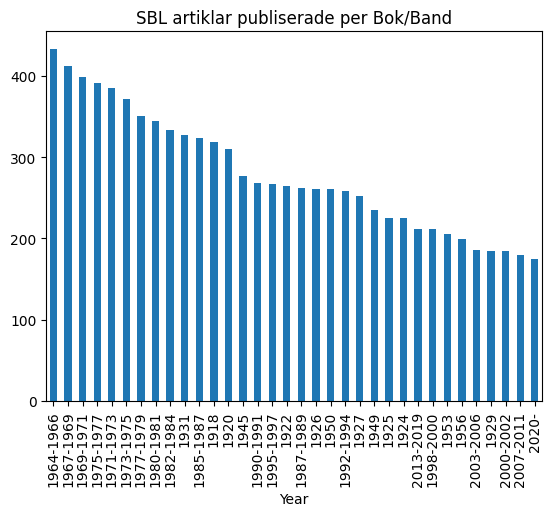

In [12]:
plotSBLYearBand.plot( kind = 'bar') 
plt.title("SBL artiklar publiserade per Bok/Band")
plt.show()

In [13]:
dfSBLcsv.sample(10)

,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year
1032,7331,36245,Anders Plomgren,"Född:1700 – Katarina församling, Stockholms län","Död:1766-06-04 – Nikolai församling, Stockholm...","Band 29 (1995-1997), sida 376.",1995-1997
7780,17701,41850,Gustaf (Gösta) Johan Anton Dunér,"Född:1840-12-20 – Billeberga församling, Skåne...","Död:1924-07-10 – Hörby församling, Skåne län (...","Band 11 (1945), sida 535.",1945
916,7094,69172,Nils J Perne,"Född:1905-05-04 – Uppsala domkyrkoförsamling, ...",Död:1965-12-27 – Kungsholm eller Ulrika Eleono...,"Band 29 (1995-1997), sida 43.",1995-1997
3464,11647,27597,"Knape, släkter",NaN,NaN,"Band 21 (1975-1977), sida 366.",1975-1977
7176,16861,22644,Vilhelm Ferdinand Ekman,"Född:1823-10-20 – Uppsala domkyrkoförsamling, ...","Död:1900-06-30 – Uppsala domkyrkoförsamling, U...","Band 12 (1949), sida 780.",1949
3302,11416,143745,Johan Henric Kellgren,"Född:1751-12-01 – Floby församling, Skaraborgs...","Död:1795-04-20 – Jakobs församling, Stockholms...","Band 21 (1975-1977), sida 23.",1975-1977
1066,7404,28864,Joachim Fredrik Preis,Född:1667 – Estland (i Dorpat/Tartu),Död:1759-12-22 – Nederländerna (i Haag),"Band 29 (1995-1997), sida 491.",1995-1997
6757,16307,65599,J (John) F Böttiger,"Född:1853-03-25 – Klara församling, Stockholms...","Död:1936-02-29 – Gustavsbergs församling, Stoc...","Band 07 (1927), sida 183.",1927
1420,8083,86324,Peder Andreæ (Svart),NaN,"Död:1562 – Västerås domkyrkoförsamling, Västma...","Band 28 (1992-1994), sida 775.",1992-1994
1369,7985,70328,Sven T Palme,"Född:1854-12-04 – Kalmar domkyrkoförsamling, K...","Död:1934-08-09 – Engelbrekts församling, Stock...","Band 28 (1992-1994), sida 609.",1992-1994


In [14]:
dfSBLcsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9497 entries, 0 to 9496
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      9497 non-null   int64 
 1   SBLlength  9497 non-null   int64 
 2   titel      9497 non-null   object
 3   Fodd       7194 non-null   object
 4   Dod        7680 non-null   object
 5   Band       9497 non-null   object
 6   Year       9491 non-null   object
dtypes: int64(2), object(5)
memory usage: 519.5+ KB


In [15]:
plotSBL = dfSBLcsv.copy()
# check year eg. empty year in https://sok.riksarkivet.se/sbl/Presentation.aspx?id=34648 --> set 2021
#dfSBLcsv["Year"]
plotSBL[plotSBL["Year"].isnull()]

,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year
9127,34648,47762,Carl Olof (Olle) Sturén,"Född:1919-02-20 – Katarina församling, Stockho...",Död:2003-05-16 – Spanien,"Band , sida .",NaN
9431,35201,14379,Bror Carl Söderblom,Född:1908,Död:1967,"Band , sida .",NaN
9444,35216,14288,Jarl Werner Söderhielm,Född:1859,Död:1931,"Band , sida .",NaN
9480,35252,14381,Ingalill Söderman,Född:1902,Död:1988,"Band , sida .",NaN
9492,35264,13643,"Blixencron, Mårten",NaN,NaN,"Band , sida .",NaN
9493,35265,12713,"Ahlgren, Ernst",NaN,NaN,"Band , sida .",NaN


In [16]:

plotSBL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9497 entries, 0 to 9496
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      9497 non-null   int64 
 1   SBLlength  9497 non-null   int64 
 2   titel      9497 non-null   object
 3   Fodd       7194 non-null   object
 4   Dod        7680 non-null   object
 5   Band       9497 non-null   object
 6   Year       9491 non-null   object
dtypes: int64(2), object(5)
memory usage: 519.5+ KB


In [17]:

#plotSBL.[plotSBL["Year"].isnull()] 
#df.replace('N/A',np.NaN)
#plotSBL['Year'] = plotSBL['Year'].replace({'np.nan': "2021"})   

plotSBL["Year"].fillna("2021", inplace = True)

In [18]:
plotSBL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9497 entries, 0 to 9496
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      9497 non-null   int64 
 1   SBLlength  9497 non-null   int64 
 2   titel      9497 non-null   object
 3   Fodd       7194 non-null   object
 4   Dod        7680 non-null   object
 5   Band       9497 non-null   object
 6   Year       9497 non-null   object
dtypes: int64(2), object(5)
memory usage: 519.5+ KB


In [19]:
import matplotlib.dates as mdates  
plotSBL["YearPublished"] = plotSBL["Year"].str[-4:] 
plotSBL.set_index('Year',inplace=True)  

In [20]:
#plotSBL["YearPublished"] = plotSBL["YearPublished"].astype("datetime64")
plotSBL["YearPublished"] = pd.to_datetime(plotSBL["YearPublished"], errors = 'coerce')

In [21]:
plotSBL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9497 entries, 1918 to 2020-
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          9497 non-null   int64         
 1   SBLlength      9497 non-null   int64         
 2   titel          9497 non-null   object        
 3   Fodd           7194 non-null   object        
 4   Dod            7680 non-null   object        
 5   Band           9497 non-null   object        
 6   YearPublished  9322 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 593.6+ KB


In [22]:
plotSBL.head()

,SBLnr,SBLlength,titel,Fodd,Dod,Band,YearPublished
Year,,,,,,,
1918,5490,12423,"Abelin, släkt",NaN,NaN,"Band 01 (1918), sida 1.",1918-01-01
1918,5491,33602,Gustaf R Abelin,Född:1819-05-17 – Linköpings Domkyrkoförsamlin...,"Död:1903-09-19 – Kvillinge församling, Östergö...","Band 01 (1918), sida 5.",1918-01-01
1918,5492,42039,Hjalmar A Abelin,Född:1817-05-22 – Linköpings Domkyrkoförsamlin...,"Död:1893-09-13 – Stockholms stad, Stockholms län","Band 01 (1918), sida 1.",1918-01-01
1918,5493,22113,C Rudolf Z Abelin,"Född:1864-05-30 – Malmö stad, Skåne län","Död:1961 – Västra Karups församling, Kristians...","Band 01 (1918), sida 9.",1918-01-01
1918,5494,27403,P Wilhelm Abenius,"Född:1864-05-21 – Orsa församling, Dalarnas län","Död:1956 – Ramsbergs församling, Örebro län","Band 01 (1918), sida 11.",1918-01-01


In [23]:
plotSBL["url"] = "https://sok.riksarkivet.se/sbl/Presentation.aspx?id=" + str(dfSBLcsv["SBLnr"])

In [24]:
#dfFamily = dfSBLAuthorcsv.dropna()  
dfPerson = plotSBL.dropna(subset = ['Fodd', 'Dod'])

In [25]:
dfPerson.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7188 entries, 1918 to 2020-
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          7188 non-null   int64         
 1   SBLlength      7188 non-null   int64         
 2   titel          7188 non-null   object        
 3   Fodd           7188 non-null   object        
 4   Dod            7188 non-null   object        
 5   Band           7188 non-null   object        
 6   YearPublished  7078 non-null   datetime64[ns]
 7   url            7188 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 505.4+ KB


### Join Wikidata
as Wikidata we guess knows what articles are about a man and a women we can try merge 

In [26]:
plotSBL['SBLnr']= plotSBL['SBLnr'].astype(str).astype(int)
plotSBL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9497 entries, 1918 to 2020-
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          9497 non-null   int64         
 1   SBLlength      9497 non-null   int64         
 2   titel          9497 non-null   object        
 3   Fodd           7194 non-null   object        
 4   Dod            7680 non-null   object        
 5   Band           9497 non-null   object        
 6   YearPublished  9322 non-null   datetime64[ns]
 7   url            9497 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 667.8+ KB


In [27]:
plotSBL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9497 entries, 1918 to 2020-
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          9497 non-null   int64         
 1   SBLlength      9497 non-null   int64         
 2   titel          9497 non-null   object        
 3   Fodd           7194 non-null   object        
 4   Dod            7680 non-null   object        
 5   Band           9497 non-null   object        
 6   YearPublished  9322 non-null   datetime64[ns]
 7   url            9497 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 667.8+ KB


In [28]:
WDSBLtot['sblid']= WDSBLtot['sblid'].astype(str).astype(int)
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          7672 non-null   object
 1   sblid        7672 non-null   int64 
 2   gender       7672 non-null   object
 3   genderLabel  7672 non-null   object
dtypes: int64(1), object(3)
memory usage: 239.9+ KB


In [29]:
WDSBLtot.head()

,wid,sblid,gender,genderLabel
0,Q132695,9140,http://www.wikidata.org/entity/Q6581097,man
1,Q242598,18364,http://www.wikidata.org/entity/Q6581072,kvinna
2,Q269812,8940,http://www.wikidata.org/entity/Q6581072,kvinna
3,Q287563,6755,http://www.wikidata.org/entity/Q6581072,kvinna
4,Q343674,7317,http://www.wikidata.org/entity/Q6581097,man


In [30]:
WDSBLtot["genderLabel"].value_counts()  

genderLabel
man         7129
kvinna       542
transman       1
Name: count, dtype: int64

In [31]:
#WDSBLtot plotSBLYearPublished  
mergeWDSBLwebscrape = pd.merge(WDSBLtot, plotSBL,how='outer',left_on='sblid', right_on='SBLnr',indicator=True)   
mergeWDSBLwebscrape.rename(columns={"_merge": "WD_Webscrape"},inplace = True)
mergeWDSBLwebscrape['WD_Webscrape'] = mergeWDSBLwebscrape['WD_Webscrape'].str.replace('left_only','WD_only').str.replace('right_only','scrape_only')
mergeWDSBLwebscrape["WD_Webscrape"].value_counts()  


WD_Webscrape
both           7670
scrape_only    1829
WD_only           2
Name: count, dtype: int64

In [32]:
dfWD_SBL_article = mergeWDSBLwebscrape[mergeWDSBLwebscrape.WD_Webscrape.str.contains("both")]
#dfWDSKBLarticle.YearPublished.dt.strftime("%Y") 
#dfWDSKBLarticle.info()  
dfWD_SBL_female_article = dfWD_SBL_article[dfWD_SBL_article.genderLabel.str.contains("kvinna")]
dfWD_SBL_female_article.head()  
# Year genderLabel count

,wid,sblid,gender,genderLabel,SBLnr,SBLlength,titel,Fodd,Dod,Band,YearPublished,url,WD_Webscrape
1,Q242598,18364.0,http://www.wikidata.org/entity/Q6581072,kvinna,18364.0,15820.0,Blanka,NaN,Död:1363,"Band 04 (1924), sida 768.",1924-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
2,Q269812,8940.0,http://www.wikidata.org/entity/Q6581072,kvinna,8940.0,63821.0,Christine Nilsson,"Född:1843-08-20 – Vederslövs församling, Krono...","Död:1921-11-22 – Växjö domkyrkoförsamling, Kro...","Band 26 (1987-1989), sida 686.",1989-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
3,Q287563,6755.0,http://www.wikidata.org/entity/Q6581072,kvinna,6755.0,19320.0,Rikissa,NaN,Död:1220-05-08,"Band 30 (1998-2000), sida 198.",2000-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
5,Q526915,15535.0,http://www.wikidata.org/entity/Q6581072,kvinna,15535.0,56355.0,Eugénie (C. Eugénie A. A. A.),"Född:1830-04-24 – Stockholms stad, Stockholms ...","Död:1889-04-23 – Stockholms stad, Stockholms l...","Band 14 (1953), sida 662.",1953-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
13,Q2925391,16949.0,http://www.wikidata.org/entity/Q6581072,kvinna,16949.0,13137.0,Brigida,NaN,Död:levde på 1100,"Band 06 (1926), sida 231.",1926-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both


In [33]:
# set date as index
#fig = plt.subplots(figsize=(15,7))

#plotSBLYearFemailPublished = dfWD_SBL_female_article["YearPublished"].dt.strftime("%Y").value_counts().sort_index().plot(kind='bar', color=['red'])

#plt.title("SBL articles published per Year about women 1918-2019")
#plt.savefig('SBL_published_articles_women_1918-2018.png')  
#plt.show()  
#plotSBLYearPublished.info 


In [34]:
#dfWD_SBL_female_article["YearPublished"].dt.strftime("%Y").value_counts().sort_index(ascending=False)

In [35]:
dfWD_SBL_female_article.head()

,wid,sblid,gender,genderLabel,SBLnr,SBLlength,titel,Fodd,Dod,Band,YearPublished,url,WD_Webscrape
1,Q242598,18364.0,http://www.wikidata.org/entity/Q6581072,kvinna,18364.0,15820.0,Blanka,NaN,Död:1363,"Band 04 (1924), sida 768.",1924-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
2,Q269812,8940.0,http://www.wikidata.org/entity/Q6581072,kvinna,8940.0,63821.0,Christine Nilsson,"Född:1843-08-20 – Vederslövs församling, Krono...","Död:1921-11-22 – Växjö domkyrkoförsamling, Kro...","Band 26 (1987-1989), sida 686.",1989-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
3,Q287563,6755.0,http://www.wikidata.org/entity/Q6581072,kvinna,6755.0,19320.0,Rikissa,NaN,Död:1220-05-08,"Band 30 (1998-2000), sida 198.",2000-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
5,Q526915,15535.0,http://www.wikidata.org/entity/Q6581072,kvinna,15535.0,56355.0,Eugénie (C. Eugénie A. A. A.),"Född:1830-04-24 – Stockholms stad, Stockholms ...","Död:1889-04-23 – Stockholms stad, Stockholms l...","Band 14 (1953), sida 662.",1953-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
13,Q2925391,16949.0,http://www.wikidata.org/entity/Q6581072,kvinna,16949.0,13137.0,Brigida,NaN,Död:levde på 1100,"Band 06 (1926), sida 231.",1926-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both


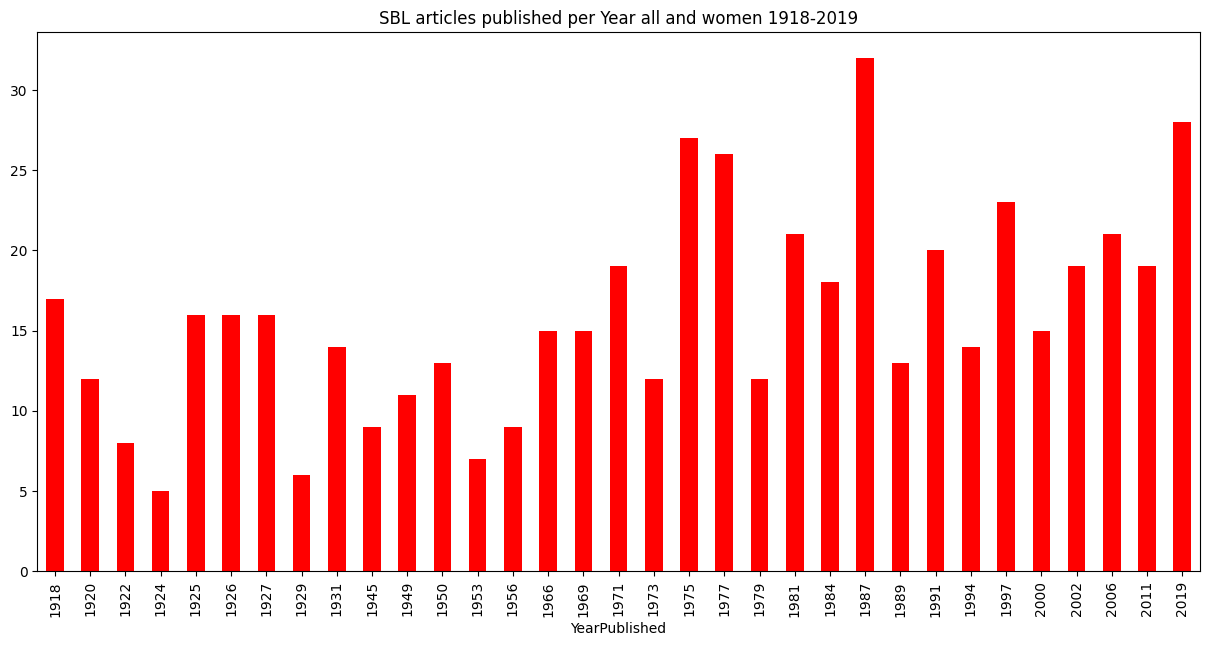

In [36]:
fig = plt.subplots(figsize=(15,7))

plotSBLYearFemailPublished = dfWD_SBL_female_article["YearPublished"].dt.strftime("%Y").value_counts().sort_index().plot(kind='bar', color=['red'])
#plotSBLYearPublished = plotSBL["YearPublished"].dt.strftime("%Y").value_counts().sort_index()
#plotSBLYearPublished.plot( kind = 'bar', color=['g']) 
plt.title("SBL articles published per Year all and women 1918-2019")
plt.savefig('SBL_published_articles_all_women_1918-2018.png')  
plt.show()  

In [37]:
speed = [0.1, 17.5, 40, 48, 52, 69, 88]
lifespan = [2, 8, 70, 1.5, 25, 12, 28]
index = ['snail', 'pig', 'elephant',
          'rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'speed': speed,
                    'lifespan': lifespan}, index=index)
#ax = df.plot.bar(rot=0)


#plotSBLYearPublished_FM = dfWD_SBL_article.groupby(["YearPublished"])
#plotSBLYearPublished_FM = dfWD_SBL_article.groupby(["YearPublished"])["genderLabel"].transform("count")
#df['Counts'] = df.groupby(['Color'])['Value'].transform('count')
#plotSBLYearPublished_FM.head()  
dfWD_SBL_article.info()
dfWD_SBL_article.head()

# Group by YearPublished genderLabel

<class 'pandas.core.frame.DataFrame'>
Index: 7670 entries, 0 to 7671
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            7670 non-null   object        
 1   sblid          7670 non-null   float64       
 2   gender         7670 non-null   object        
 3   genderLabel    7670 non-null   object        
 4   SBLnr          7670 non-null   float64       
 5   SBLlength      7670 non-null   float64       
 6   titel          7670 non-null   object        
 7   Fodd           7148 non-null   object        
 8   Dod            7629 non-null   object        
 9   Band           7670 non-null   object        
 10  YearPublished  7599 non-null   datetime64[ns]
 11  url            7670 non-null   object        
 12  WD_Webscrape   7670 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(9)
memory usage: 838.9+ KB


,wid,sblid,gender,genderLabel,SBLnr,SBLlength,titel,Fodd,Dod,Band,YearPublished,url,WD_Webscrape
0,Q132695,9140.0,http://www.wikidata.org/entity/Q6581097,man,9140.0,207586.0,Harry E Martinson,"Född:1904-05-06 – Jämshögs församling, Bleking...","Död:1978-02-11 – Sollentuna församling, Stockh...","Band 25 (1985-1987), sida 204.",1987-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
1,Q242598,18364.0,http://www.wikidata.org/entity/Q6581072,kvinna,18364.0,15820.0,Blanka,NaN,Död:1363,"Band 04 (1924), sida 768.",1924-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
2,Q269812,8940.0,http://www.wikidata.org/entity/Q6581072,kvinna,8940.0,63821.0,Christine Nilsson,"Född:1843-08-20 – Vederslövs församling, Krono...","Död:1921-11-22 – Växjö domkyrkoförsamling, Kro...","Band 26 (1987-1989), sida 686.",1989-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
3,Q287563,6755.0,http://www.wikidata.org/entity/Q6581072,kvinna,6755.0,19320.0,Rikissa,NaN,Död:1220-05-08,"Band 30 (1998-2000), sida 198.",2000-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both
4,Q343674,7317.0,http://www.wikidata.org/entity/Q6581097,man,7317.0,45404.0,"Baltzar J E Platen, von","Född:1804-04-16 – Näs församling (R-län), Skar...","Död:1875-03-20 – Jakobs församling, Stockholms...","Band 29 (1995-1997), sida 359.",1997-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,both


### Släktartiklar  
Nedan lite gissning att en släktartikel har ordet släkt i titeln. 

* se också [webscarping Adelsvapen](https://gist.github.com/salgo60/31e0c4bf6f075c373fb5bbfb6cc807c6)
* csv lista skapad nedan på [GIST](https://gist.github.com/salgo60/31e0c4bf6f075c373fb5bbfb6cc807c6#gistcomment-3457126) 

In [38]:
#dfFamily = plotSBL[plotSBL.isnull().any(1)] 
dfFamily = plotSBL[plotSBL.isnull().any(axis=1)]

In [39]:
dfFamily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, 1918 to 2020-
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          2419 non-null   int64         
 1   SBLlength      2419 non-null   int64         
 2   titel          2419 non-null   object        
 3   Fodd           116 non-null    object        
 4   Dod            602 non-null    object        
 5   Band           2419 non-null   object        
 6   YearPublished  2244 non-null   datetime64[ns]
 7   url            2419 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 170.1+ KB


In [40]:
#dfFamily

In [41]:
dfFamilySlakt = dfFamily[dfFamily.titel.str.contains("släkt")]
#dfFamilySlakt

In [42]:
dictFamily = dfFamilySlakt.to_dict()

In [43]:
dfFamily.titel.str.contains("släkt").sum()

1718

In [44]:
dfFamily.titel.str.contains("ätten").sum()

28

In [45]:
dfFamily.titel.str.contains("Släkt").sum()

1

In [46]:
dfFamily.Dod.str.contains("senas").sum()

23

In [47]:
#dfFamily[dfFamily.Dod.str.contains("senas", na=False)]

In [48]:
dfFamily[dfFamily.Fodd.str.contains("", na=False)].sample(10)

,SBLnr,SBLlength,titel,Fodd,Dod,Band,YearPublished,url
Year,,,,,,,,
2020-,35131,41992,Gertie Söderberg,Född:1892-09-24 – Tyska Sankta Gertruds försam...,"Död:1983-06-12 – Västerleds församling, Stockh...","Band 35 (2020-), sida 241.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...
2020-,35244,78345,Harry Söderman,"Född:1902-08-24 – Hedvig Eleonora församling, ...",Död:1956-03-16 – Marocko (Tanger),"Band 35 (2020-), sida 438.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...
2020-,35004,51010,Stig Gustaf Eugén Synnergren,"Född:1915-02-25 – Överluleå församling, Norrbo...","Död:2004-04-28 – Hedvig Eleonora församling, S...","Band 35 (2020-), sida 138.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...
2020-,35135,30830,Johan Söderberg,"Född:1772-01-06 – Gåsinge församling, Söderman...","Död:1820-12-13 – Maria Magdalena församling, S...","Band 35 (2020-), sida 252.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...
1931,15784,33079,Magnus E. Dahlander,"Född:1862-08-02 – Säters stadsförsamling, Dala...",NaN,"Band 09 (1931), sida 592.",1931-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...
2020-,35023,51191,Valborg Josefina Svärdström,Född:1879-12-22 – Gävle Heliga Trefaldighets f...,"Död:1972-02-01 – Tyskland (Eckwälden-Bad Boll,...","Band 35 (2020-), sida 53.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...
2020-,34989,69932,Dagmar Barbro Margaret Svinhufvud,Född:1909-09-07 – Stockholms katolska församli...,"Död:1991-07-22 – Danderyds församling, Stockho...","Band 35 (2020-), sida 32.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...
2020-,35182,45503,Fritz Enoch August Söderbergh,"Född:1865-03-29 – Karlshamns församling, Bleki...","Död:1948-09-11 – Johannes församling, Stockhol...","Band 35 (2020-), sida 331.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...
2020-,35082,57182,Carl Tarras Sällfors,Född:1898-04-01 – Helsingborgs Maria församlin...,"Död:1960-03-17 – Oscars församling, Stockholms...","Band 35 (2020-), sida 176.",NaT,https://sok.riksarkivet.se/sbl/Presentation.as...


In [49]:
#Check diff WDSBLtot and plotSBL 
WDSBLtot.duplicated(subset=['wid']).sum()

3

In [50]:
plotSBL.duplicated(subset=['SBLnr']).sum()

0

In [51]:
#WDSBLtot.duplicated(subset=['sblid']).sum()

In [52]:
WDSBLtot = WDSBLtot.rename(columns={'sblid':'SBLnr'})
WDSBLtot['SBLnr']= WDSBLtot['SBLnr'].astype(str).astype(int)
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          7672 non-null   object
 1   SBLnr        7672 non-null   int64 
 2   gender       7672 non-null   object
 3   genderLabel  7672 non-null   object
dtypes: int64(1), object(3)
memory usage: 239.9+ KB


In [53]:
dfmerge = pd.merge(WDSBLtot, plotSBL,how='outer', on='SBLnr',indicator=True)

In [54]:
dfmerge["_merge"].value_counts()

_merge
both          7670
right_only    1829
left_only        2
Name: count, dtype: int64

In [55]:
#dfmerge

In [56]:
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','SBL_only')


In [57]:
WDSBLonly = dfmerge[dfmerge["_merge"] == "SBL_only"].copy()   
dfmerge["_merge"].value_counts()

_merge
both        7670
SBL_only    1829
WD_only        2
Name: count, dtype: int64

In [58]:
WD_only = dfmerge[dfmerge["_merge"] == "WD_only"].copy()   
WD_only

,wid,SBLnr,gender,genderLabel,SBLlength,titel,Fodd,Dod,Band,YearPublished,url,_merge
6960,Q6195917,34715,http://www.wikidata.org/entity/Q6581097,man,NaN,NaN,NaN,NaN,NaN,NaT,NaN,WD_only
7386,Q123513653,35150,http://www.wikidata.org/entity/Q6581072,kvinna,NaN,NaN,NaN,NaN,NaN,NaT,NaN,WD_only


In [59]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1829 entries, 7672 to 9500
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            0 non-null      object        
 1   SBLnr          1829 non-null   int64         
 2   gender         0 non-null      object        
 3   genderLabel    0 non-null      object        
 4   SBLlength      1829 non-null   float64       
 5   titel          1829 non-null   object        
 6   Fodd           47 non-null     object        
 7   Dod            53 non-null     object        
 8   Band           1829 non-null   object        
 9   YearPublished  1725 non-null   datetime64[ns]
 10  url            1829 non-null   object        
 11  _merge         1829 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 185.8+ KB


In [60]:
WDSBLonly.titel.str.contains("släkt").sum() 


1681

In [61]:
WDSBLonly[WDSBLonly.titel.str.contains("ätt")].head(10)

,wid,SBLnr,gender,genderLabel,SBLlength,titel,Fodd,Dod,Band,YearPublished,url,_merge
7778,NaN,7249,NaN,NaN,23875.0,"Pfalziska ätten,",NaN,NaN,"Band 29 (1995-1997), sida 283.",1997-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
7894,NaN,9007,NaN,NaN,42169.0,"Malsta-ätten,",NaN,NaN,"Band 25 (1985-1987), sida 40.",1987-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8088,NaN,11237,NaN,NaN,42479.0,"Lepasätten, släkt",NaN,NaN,"Band 22 (1977-1979), sida 579.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8100,NaN,11376,NaN,NaN,38271.0,"Likvidssönernas ätt,",NaN,NaN,"Band 22 (1977-1979), sida 767.",1979-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8279,NaN,12565,NaN,NaN,23136.0,"Hammerstaätten,",NaN,NaN,"Band 18 (1969-1971), sida 224.",1971-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8367,NaN,13016,NaN,NaN,23007.0,"Gera, ätt",NaN,NaN,"Band 17 (1967-1969), sida 71.",1969-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8384,NaN,13096,NaN,NaN,18229.0,"Glysing, ätt",NaN,NaN,"Band 17 (1967-1969), sida 165.",1969-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8404,NaN,13177,NaN,NaN,17264.0,"Gren, ätt",NaN,NaN,"Band 17 (1967-1969), sida 258.",1969-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8500,NaN,13783,NaN,NaN,29205.0,"Holstein-Gottorpska ätten,",NaN,NaN,"Band 19 (1971-1973), sida 323.",1973-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8562,NaN,14142,NaN,NaN,27297.0,"Finstaätten,",NaN,NaN,"Band 16 (1964-1966), sida 51.",1966-01-01,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only


In [62]:
#Inte släkt 
WDmissingPerson = WDSBLonly[~WDSBLonly.titel.str.contains("släkt")]

In [63]:
WDmissingPerson.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, 7680 to 9500
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            0 non-null      object        
 1   SBLnr          148 non-null    int64         
 2   gender         0 non-null      object        
 3   genderLabel    0 non-null      object        
 4   SBLlength      148 non-null    float64       
 5   titel          148 non-null    object        
 6   Fodd           47 non-null     object        
 7   Dod            53 non-null     object        
 8   Band           148 non-null    object        
 9   YearPublished  55 non-null     datetime64[ns]
 10  url            148 non-null    object        
 11  _merge         148 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 15.0+ KB


In [64]:
WDmissingPerson["YearPublished"].value_counts()

YearPublished
1931-01-01    12
1966-01-01     7
1953-01-01     5
1950-01-01     5
2021-01-01     5
1975-01-01     3
1969-01-01     3
2019-01-01     2
1979-01-01     1
1971-01-01     1
1973-01-01     1
1997-01-01     1
1929-01-01     1
1987-01-01     1
1991-01-01     1
1994-01-01     1
1924-01-01     1
1920-01-01     1
1925-01-01     1
1984-01-01     1
1918-01-01     1
Name: count, dtype: int64

In [65]:
print("Min, Max SBLlength: ", WDmissingPerson.SBLlength.min(), WDmissingPerson.SBLlength.max())

Min, Max SBLlength:  12006.0 110347.0


In [66]:
# sorterar artiklarna efter sidstorlek för att kanske hitta någon vi missat  
# wid är Wikidata objekt , NaN är att det saknas  
# SBLnr är id i SBL
# SBLlength är sidans storlek hos SBL 
# Fodd, Dod... är det jag hittade i WEBsidan, NaN innebär saknas

#WDmissingPerson.sort_values(by='SBLlength', ascending=False, na_position='first')

In [67]:
WDmissingPerson.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, 7680 to 9500
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            0 non-null      object        
 1   SBLnr          148 non-null    int64         
 2   gender         0 non-null      object        
 3   genderLabel    0 non-null      object        
 4   SBLlength      148 non-null    float64       
 5   titel          148 non-null    object        
 6   Fodd           47 non-null     object        
 7   Dod            53 non-null     object        
 8   Band           148 non-null    object        
 9   YearPublished  55 non-null     datetime64[ns]
 10  url            148 non-null    object        
 11  _merge         148 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 15.0+ KB


In [68]:
WDmissingPerson["YearPublished"].value_counts()

YearPublished
1931-01-01    12
1966-01-01     7
1953-01-01     5
1950-01-01     5
2021-01-01     5
1975-01-01     3
1969-01-01     3
2019-01-01     2
1979-01-01     1
1971-01-01     1
1973-01-01     1
1997-01-01     1
1929-01-01     1
1987-01-01     1
1991-01-01     1
1994-01-01     1
1924-01-01     1
1920-01-01     1
1925-01-01     1
1984-01-01     1
1918-01-01     1
Name: count, dtype: int64

In [69]:
print("End run: ", datetime.now())

End run:  2025-03-06 02:13:57.797152


In [70]:
#Släkt 
#WDSlakt = WDSBLonly[~WDSBLonly.titel.str.contains("släkt")].copy

In [71]:
WDSlakt = WDSBLonly[WDSBLonly.titel.str.contains("släkt")]

In [72]:
WDSlakt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1681 entries, 7672 to 9481
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            0 non-null      object        
 1   SBLnr          1681 non-null   int64         
 2   gender         0 non-null      object        
 3   genderLabel    0 non-null      object        
 4   SBLlength      1681 non-null   float64       
 5   titel          1681 non-null   object        
 6   Fodd           0 non-null      object        
 7   Dod            0 non-null      object        
 8   Band           1681 non-null   object        
 9   YearPublished  1670 non-null   datetime64[ns]
 10  url            1681 non-null   object        
 11  _merge         1681 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 170.7+ KB


In [73]:
#Need a workaround as pandas to_csv dont work ?!?!?
#for  index,row in WDSlakt.iterrows():
#    print(row["SBLnr"],row["titel"],row["Year"],row["url"])    
#    print(row["SBLnr"],"|",row["titel"],"|",row["Year"])  

List produced also on [GIST](https://gist.github.com/salgo60/31e0c4bf6f075c373fb5bbfb6cc807c6#gistcomment-3457126) 

### Estimate published articles male/female /family


In [74]:
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9501 entries, 0 to 9500
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            7672 non-null   object        
 1   SBLnr          9501 non-null   int64         
 2   gender         7672 non-null   object        
 3   genderLabel    7672 non-null   object        
 4   SBLlength      9499 non-null   float64       
 5   titel          9499 non-null   object        
 6   Fodd           7195 non-null   object        
 7   Dod            7682 non-null   object        
 8   Band           9499 non-null   object        
 9   YearPublished  9324 non-null   datetime64[ns]
 10  url            9499 non-null   object        
 11  _merge         9501 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 890.8+ KB


In [75]:
personSBL = dfmerge[~dfmerge['wid'].isnull()] 

In [76]:
personSBL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7672 entries, 0 to 7671
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            7672 non-null   object        
 1   SBLnr          7672 non-null   int64         
 2   gender         7672 non-null   object        
 3   genderLabel    7672 non-null   object        
 4   SBLlength      7670 non-null   float64       
 5   titel          7670 non-null   object        
 6   Fodd           7148 non-null   object        
 7   Dod            7629 non-null   object        
 8   Band           7670 non-null   object        
 9   YearPublished  7599 non-null   datetime64[ns]
 10  url            7670 non-null   object        
 11  _merge         7672 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 779.2+ KB


### Check highest numbers SBL and WD/SBL

In [77]:
sorted_df = personSBL.sort_values(by='SBLnr', ascending=False)

# Select the top 10 rows
top_10_SBLnr = sorted_df.head(10)

# Display the top 10 SBLnr values
top_10_SBLnr['SBLnr']

6452    35255
7089    35168
665     35158
7386    35150
2424    35148
6635    35147
5103    35146
7604    35145
3728    35144
660     35143
Name: SBLnr, dtype: int64

In [78]:
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          7672 non-null   object
 1   SBLnr        7672 non-null   int64 
 2   gender       7672 non-null   object
 3   genderLabel  7672 non-null   object
dtypes: int64(1), object(3)
memory usage: 239.9+ KB


In [79]:
# Sort the DataFrame by sblid in descending order
sorted_wddf = WDSBLtot.sort_values(by='SBLnr', ascending=False)

# Select the top 10 rows
top_10_wdsblid = sorted_wddf.head(10)

# Display the top 100 sblid values
top_10_wdsblid['SBLnr']


6452    35255
7089    35168
665     35158
7386    35150
2424    35148
6635    35147
5103    35146
7604    35145
3728    35144
660     35143
Name: SBLnr, dtype: int64

# Plot Gender distribution

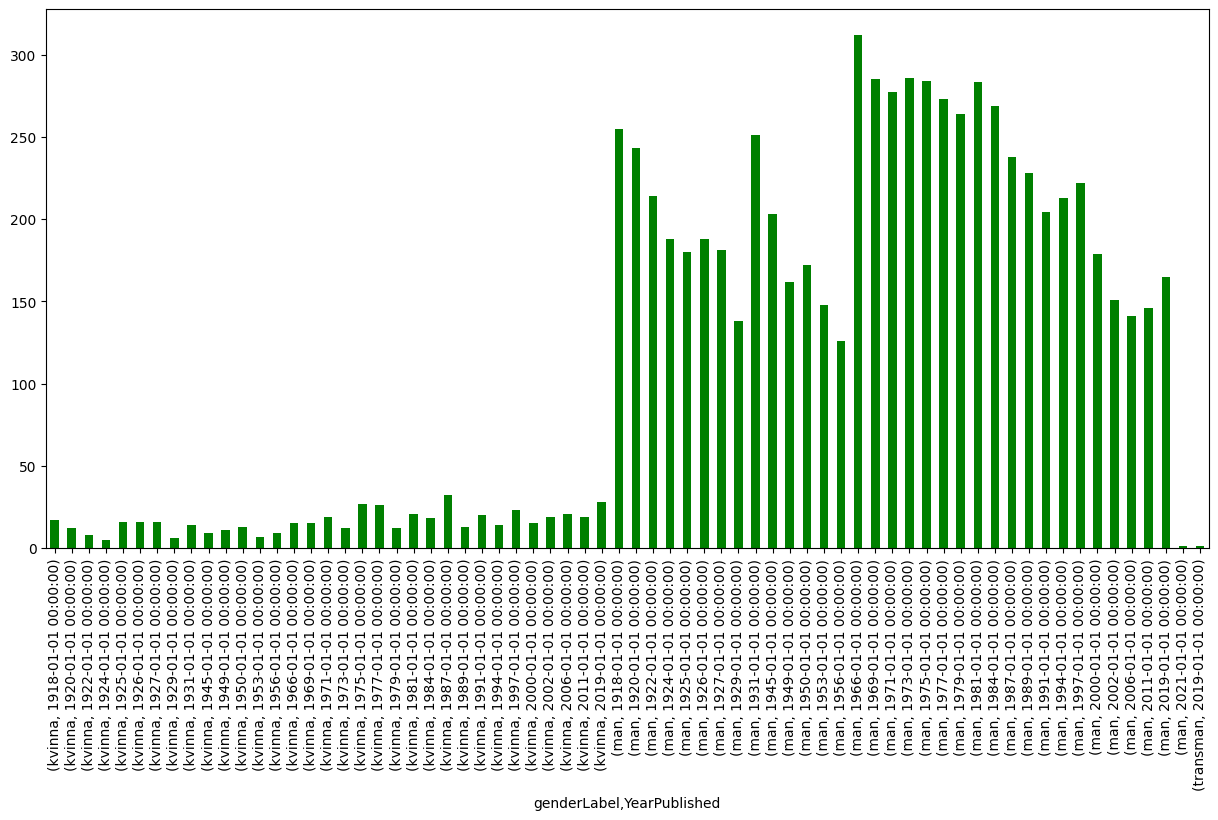

In [80]:
fig = plt.subplots(figsize=(15,7))
plotSBLGender = personSBL.groupby(["genderLabel", "YearPublished"]).size()
#plotSBLGender  
plotSBLGender.plot( kind = 'bar', color=['g'],) 
plt.show()

In [81]:
#plotSBLGender = personSBL.groupby(["genderLabel", "YearPublished"]).size()
personSBL.info()
#plotSBLGender.pivot("genderLabel", "YearPublished")

<class 'pandas.core.frame.DataFrame'>
Index: 7672 entries, 0 to 7671
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            7672 non-null   object        
 1   SBLnr          7672 non-null   int64         
 2   gender         7672 non-null   object        
 3   genderLabel    7672 non-null   object        
 4   SBLlength      7670 non-null   float64       
 5   titel          7670 non-null   object        
 6   Fodd           7148 non-null   object        
 7   Dod            7629 non-null   object        
 8   Band           7670 non-null   object        
 9   YearPublished  7599 non-null   datetime64[ns]
 10  url            7670 non-null   object        
 11  _merge         7672 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 779.2+ KB


In [82]:
plotSBLGender.unstack()

YearPublished,1918-01-01,1920-01-01,1922-01-01,1924-01-01,1925-01-01,1926-01-01,1927-01-01,1929-01-01,1931-01-01,1945-01-01,...,1989-01-01,1991-01-01,1994-01-01,1997-01-01,2000-01-01,2002-01-01,2006-01-01,2011-01-01,2019-01-01,2021-01-01
genderLabel,,,,,,,,,,,,,,,,,,,,,
kvinna,17.0,12.0,8.0,5.0,16.0,16.0,16.0,6.0,14.0,9.0,...,13.0,20.0,14.0,23.0,15.0,19.0,21.0,19.0,28.0,NaN
man,255.0,243.0,214.0,188.0,180.0,188.0,181.0,138.0,251.0,203.0,...,228.0,204.0,213.0,222.0,179.0,151.0,141.0,146.0,165.0,1.0
transman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [83]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - startdate))

Ended:  2025-03-06 02:13:58.126794
Time elapsed (hh:mm:ss.ms) 0:20:31.102081
